<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob, os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FILE NAME: 210902_#8_150_20_1um_i004.tif
DATE: 09/03/2021
PIXEL SIZE: 2.480469 nm
IMAGE SIZE: 2560x1920


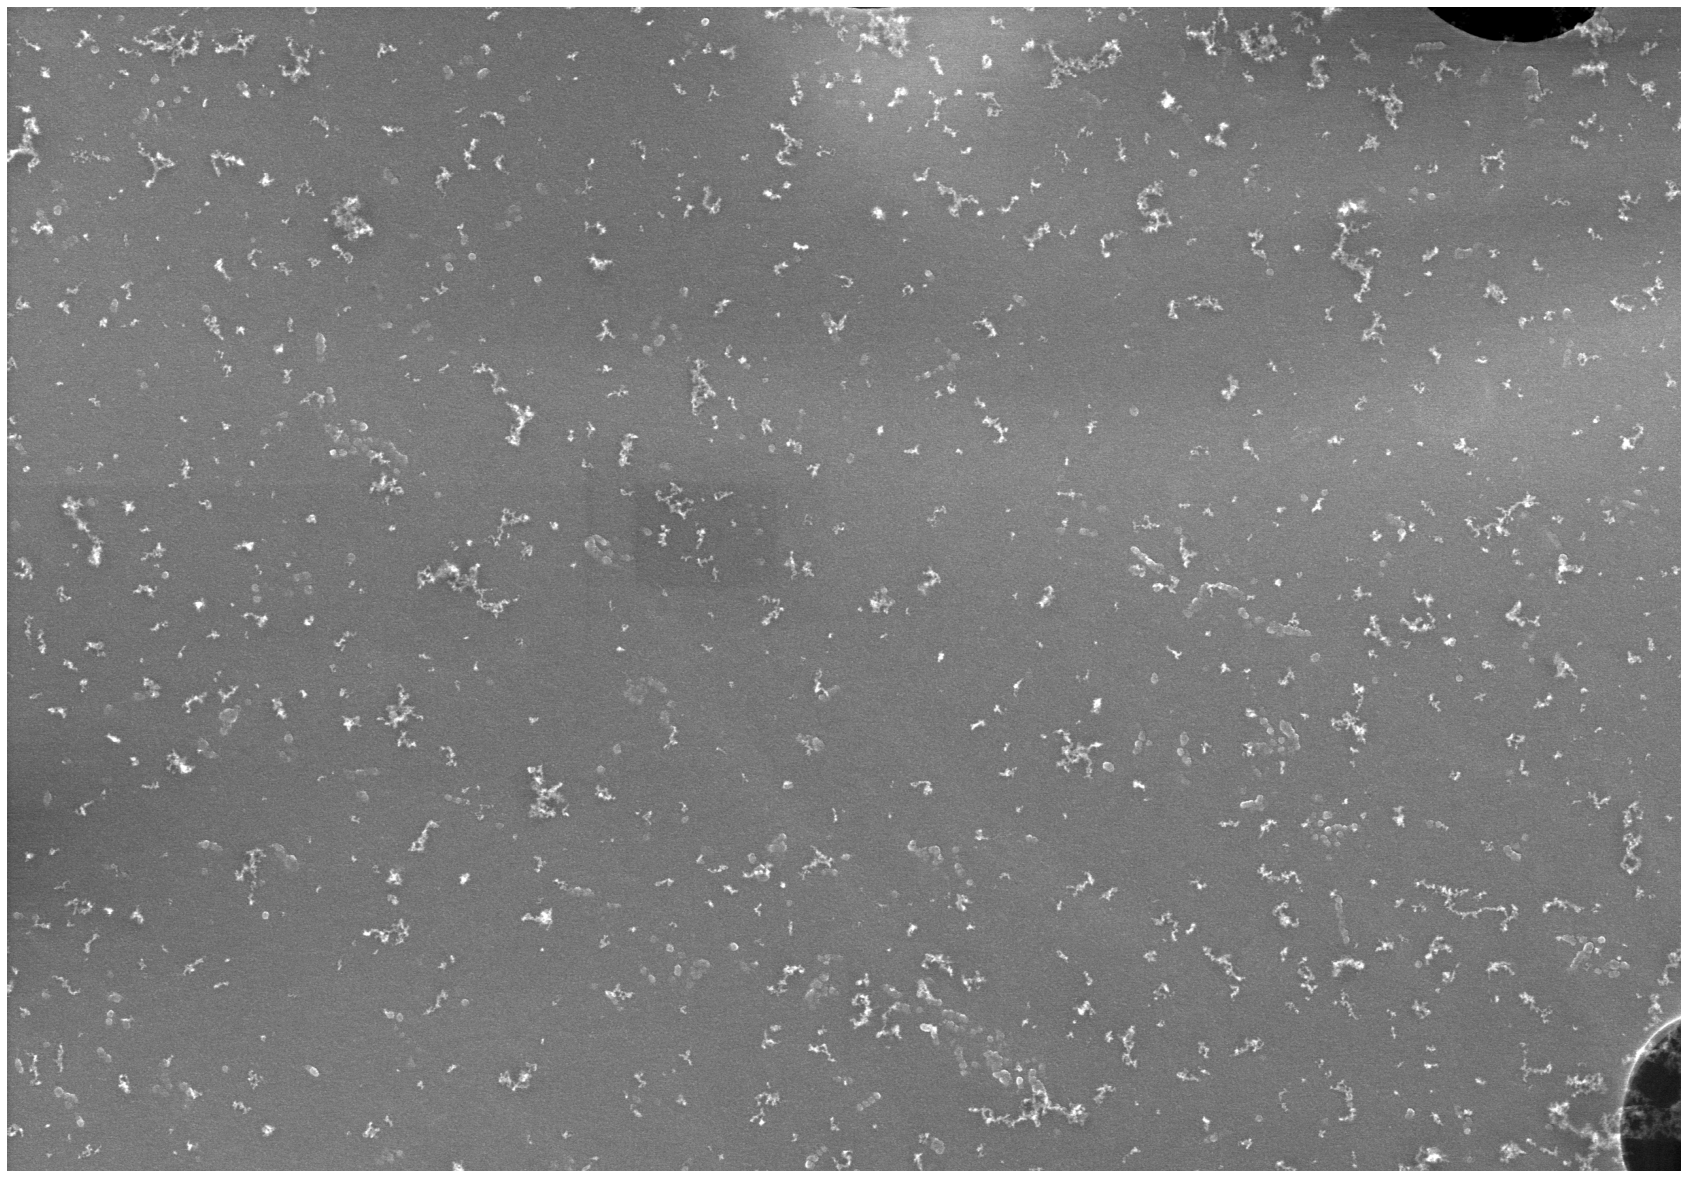

In [542]:
img = io.imread('/content/drive/MyDrive/CIOP/images/210902_#8_150_20_1um_i004.tif', as_gray=True)
img = np.array(img).astype(np.float32)

with open(f'/content/drive/MyDrive/CIOP/images/210902_#8_150_20_1um_i004.txt','r') as txt_file:
    txt = txt_file.read()
    del txt_file
    txt=txt.split('\n')
    txt=txt[1:-1]
    sem_dict = {}
    for row in txt:
        row = row.split('=')
        sem_dict.update({row[0]:  row[1]}) 
    print('FILE NAME:',sem_dict['ImageName'])
    print('DATE:',sem_dict['Date'] )    
    print('PIXEL SIZE:', sem_dict['PixelSize'],'nm')
    print('IMAGE SIZE:', sem_dict['DataSize'])
    pixelsize = float(sem_dict['PixelSize'])
    width, height = sem_dict['DataSize'].split('x')
    width, height = int(width), int(height)
    if height == 1920:
        img = img[0:1780,0:2560]
        height = 1780
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(img,vmax=255, cmap='gray')
plt.show()

Max: 255.0
Min: 0.0
Median: 122.0
Average: 124.29513
IMAGE:


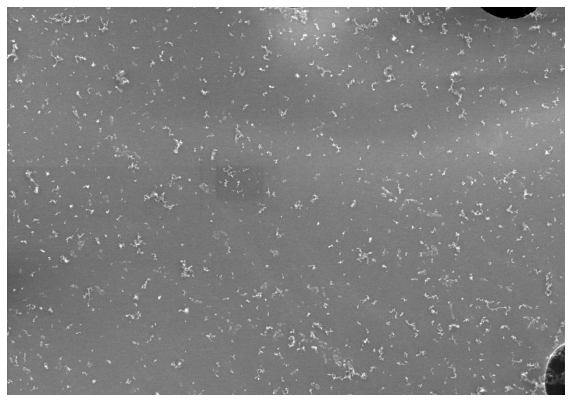

IMAGE HIST:


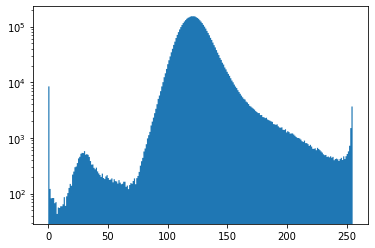

Average:


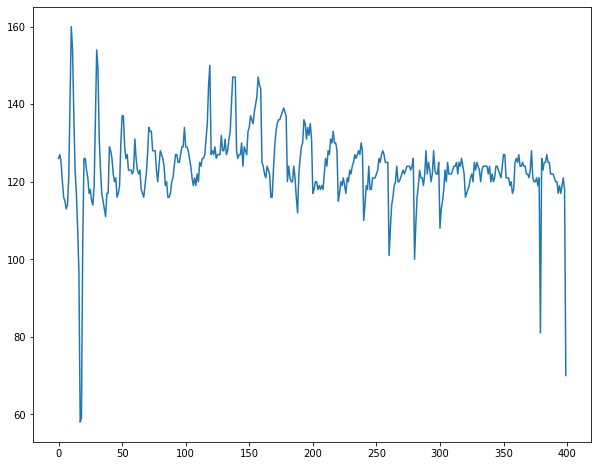

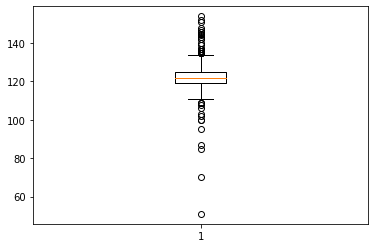

119.0
125.0
134.0
110.0
Median_HM


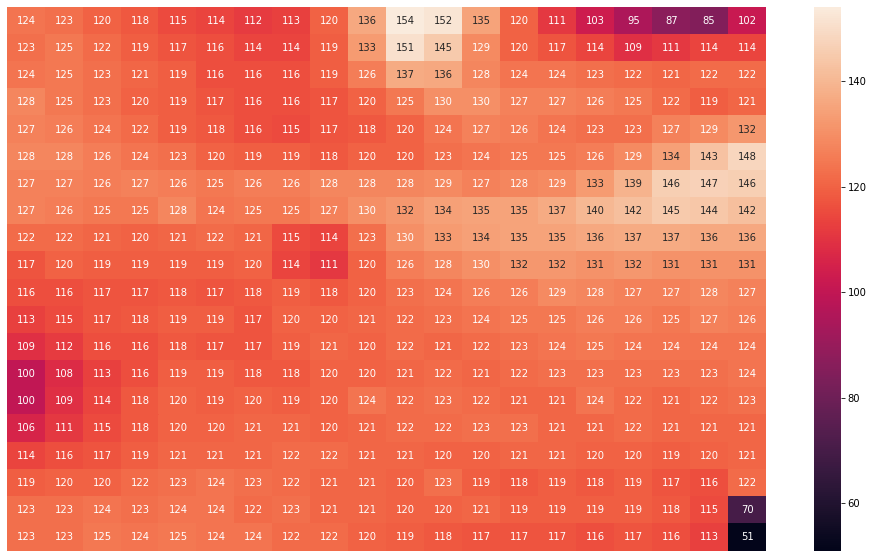

Average_HM


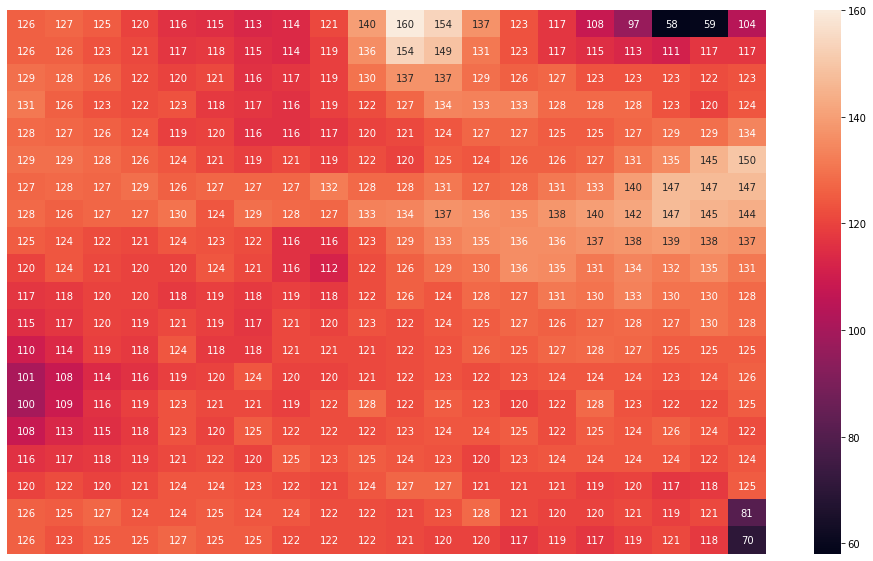

max/median_HM


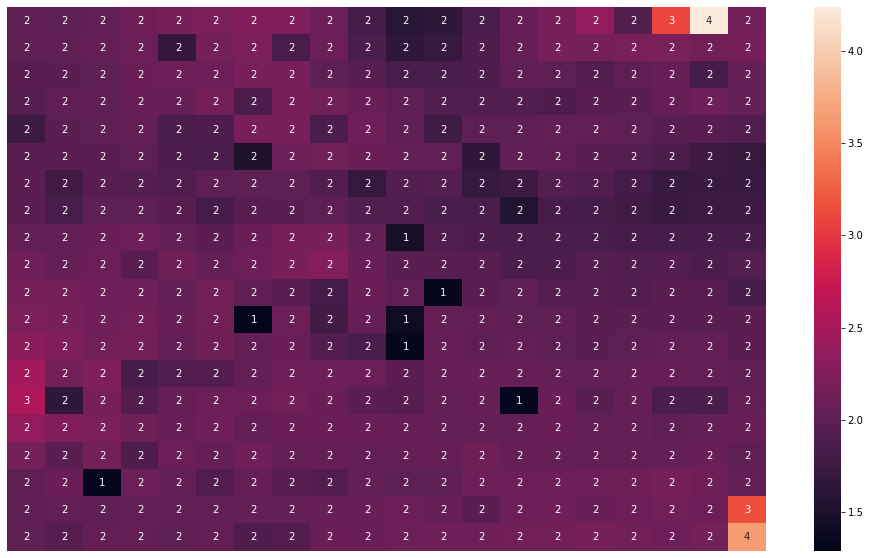

In [544]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    im_flatten = im.flatten()
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.yscale('log')
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    plt.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
image_info(img)

In [483]:
img.shape

(1780, 2560)

In [545]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    mask = np.ones(shape=(1780,2560), dtype=bool)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            median_img.append(np.median(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    Q1 = np.percentile(median_img , 25)
    Q3 = np.percentile(median_img , 75)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)

    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > upper_bound or np.median(img[x_min:x_max,y_min:y_max]) < lower_bound :
                print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 0
                mask[x_min:x_max,y_min:y_max] = False
    img2[img2<0] = 0
    mask[0,0:]=False
    mask[-1,0:]=False
    mask[0:,0]=False
    mask[0:,-1]=False
    return img2, median_img, median_img2,mask
img2, median_img,median_img2,mask = uniform(20,20)

Median Rectangle Box size: 89 x 128
Median intensity: 122.0
136.0
154.0
152.0
135.0
103.0
95.0
87.0
85.0
102.0
151.0
145.0
109.0
137.0
136.0
143.0
148.0
139.0
146.0
147.0
146.0
135.0
135.0
137.0
140.0
142.0
145.0
144.0
142.0
135.0
135.0
136.0
137.0
137.0
136.0
136.0
109.0
100.0
108.0
100.0
109.0
106.0
70.0
51.0


In [546]:
mask

array([[False, False, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       ...,
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

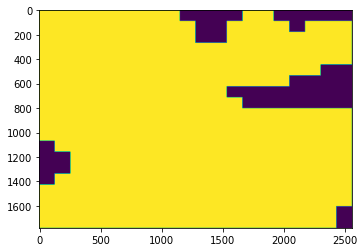

In [547]:
plt.imshow(mask)

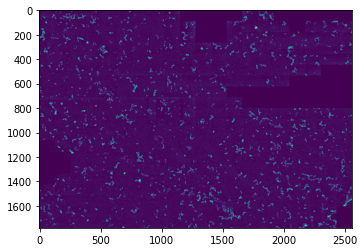

In [548]:
plt.imshow(img2)

Max: 144.0
Min: 0.0
Median: 0.0
Average: 5.285898
IMAGE:


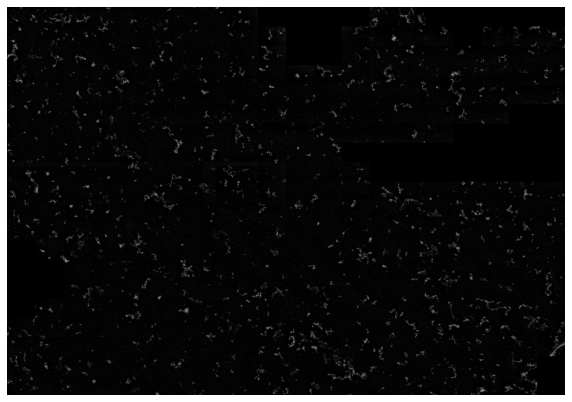

IMAGE HIST:


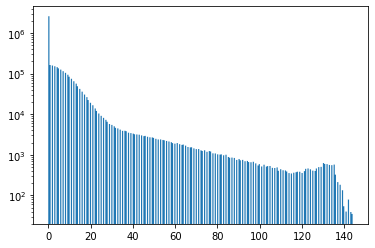

Average:


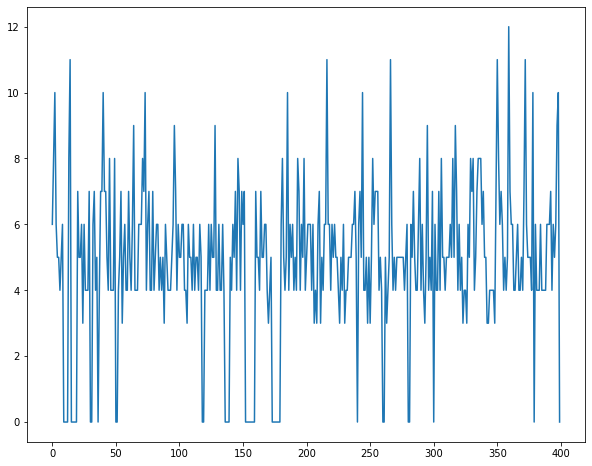

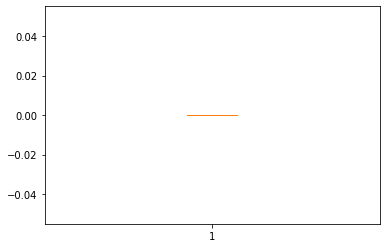

0.0
0.0
0.0
0.0
Median_HM


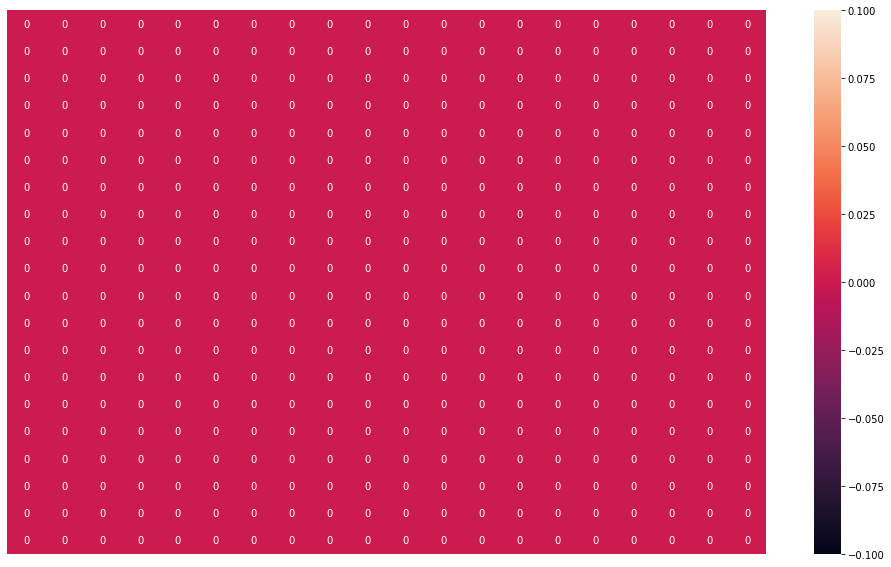

Average_HM


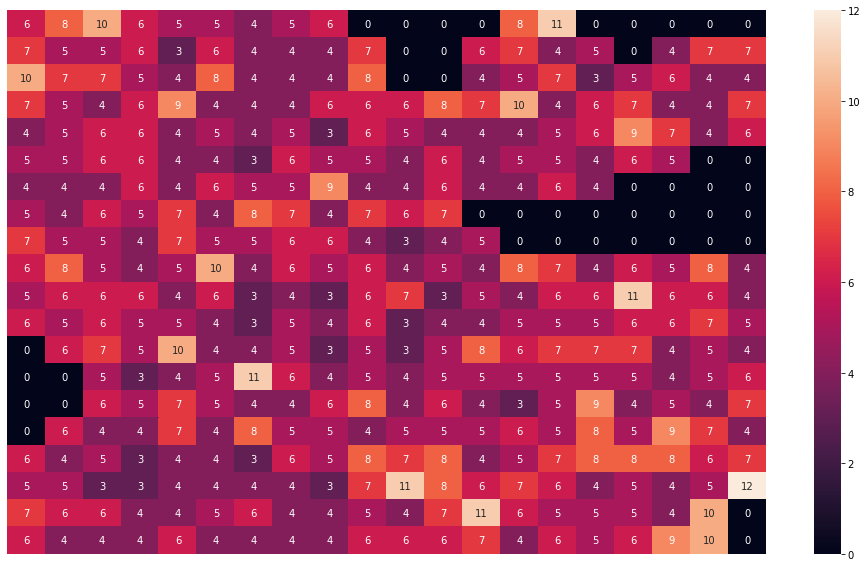

max/median_HM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


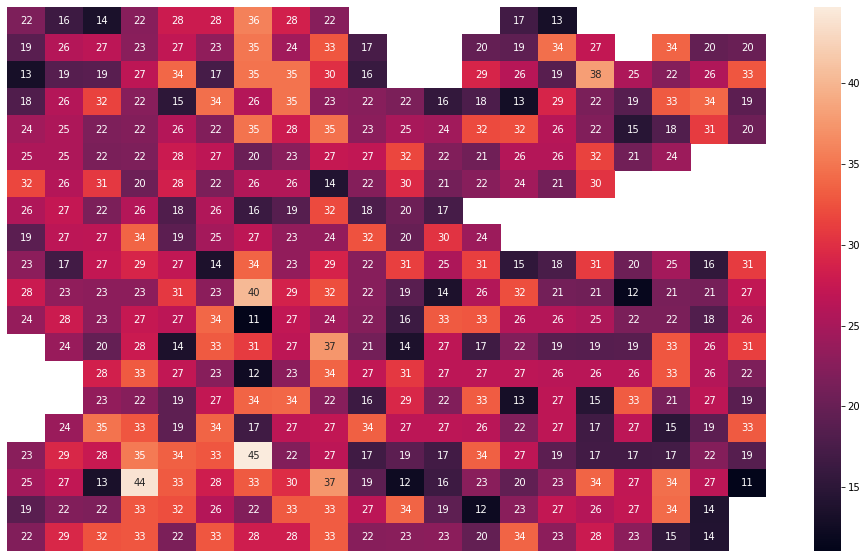

In [549]:
image_info(img2)

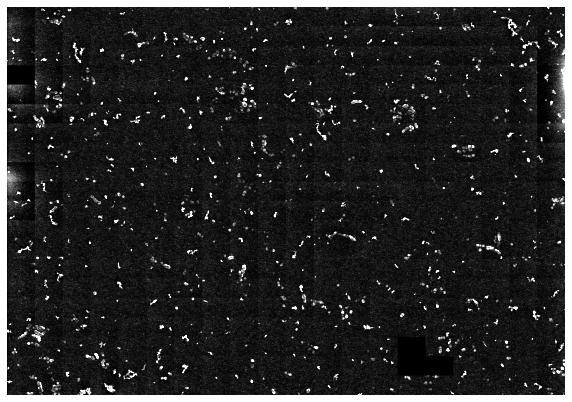

In [234]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=40, cmap='gray')
plt.show()

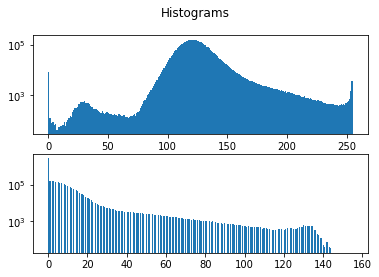

In [550]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))
histograms()

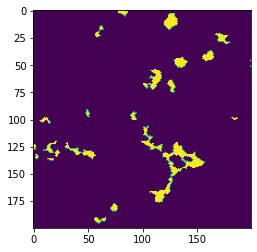

In [551]:
def segmentation(low,denoise,small,erosion=1):
    img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = morphology.remove_small_objects(img_segm, small)

    for i in range(erosion):
        img_segm = morphology.binary_erosion(img_segm)
    img_segm = morphology.remove_small_objects(img_segm, small)
    for i in range(erosion-1):     
        img_segm = morphology.binary_dilation(img_segm)
   # img_segm = morphology.binary_dilation(img_segm)
    #img_segm = morphology.binary_erosion(img_segm)
    plt.imshow(img_segm[100:300,100:300])
    plt.show()
    return img_segm

img_segm = segmentation(5,6,10)

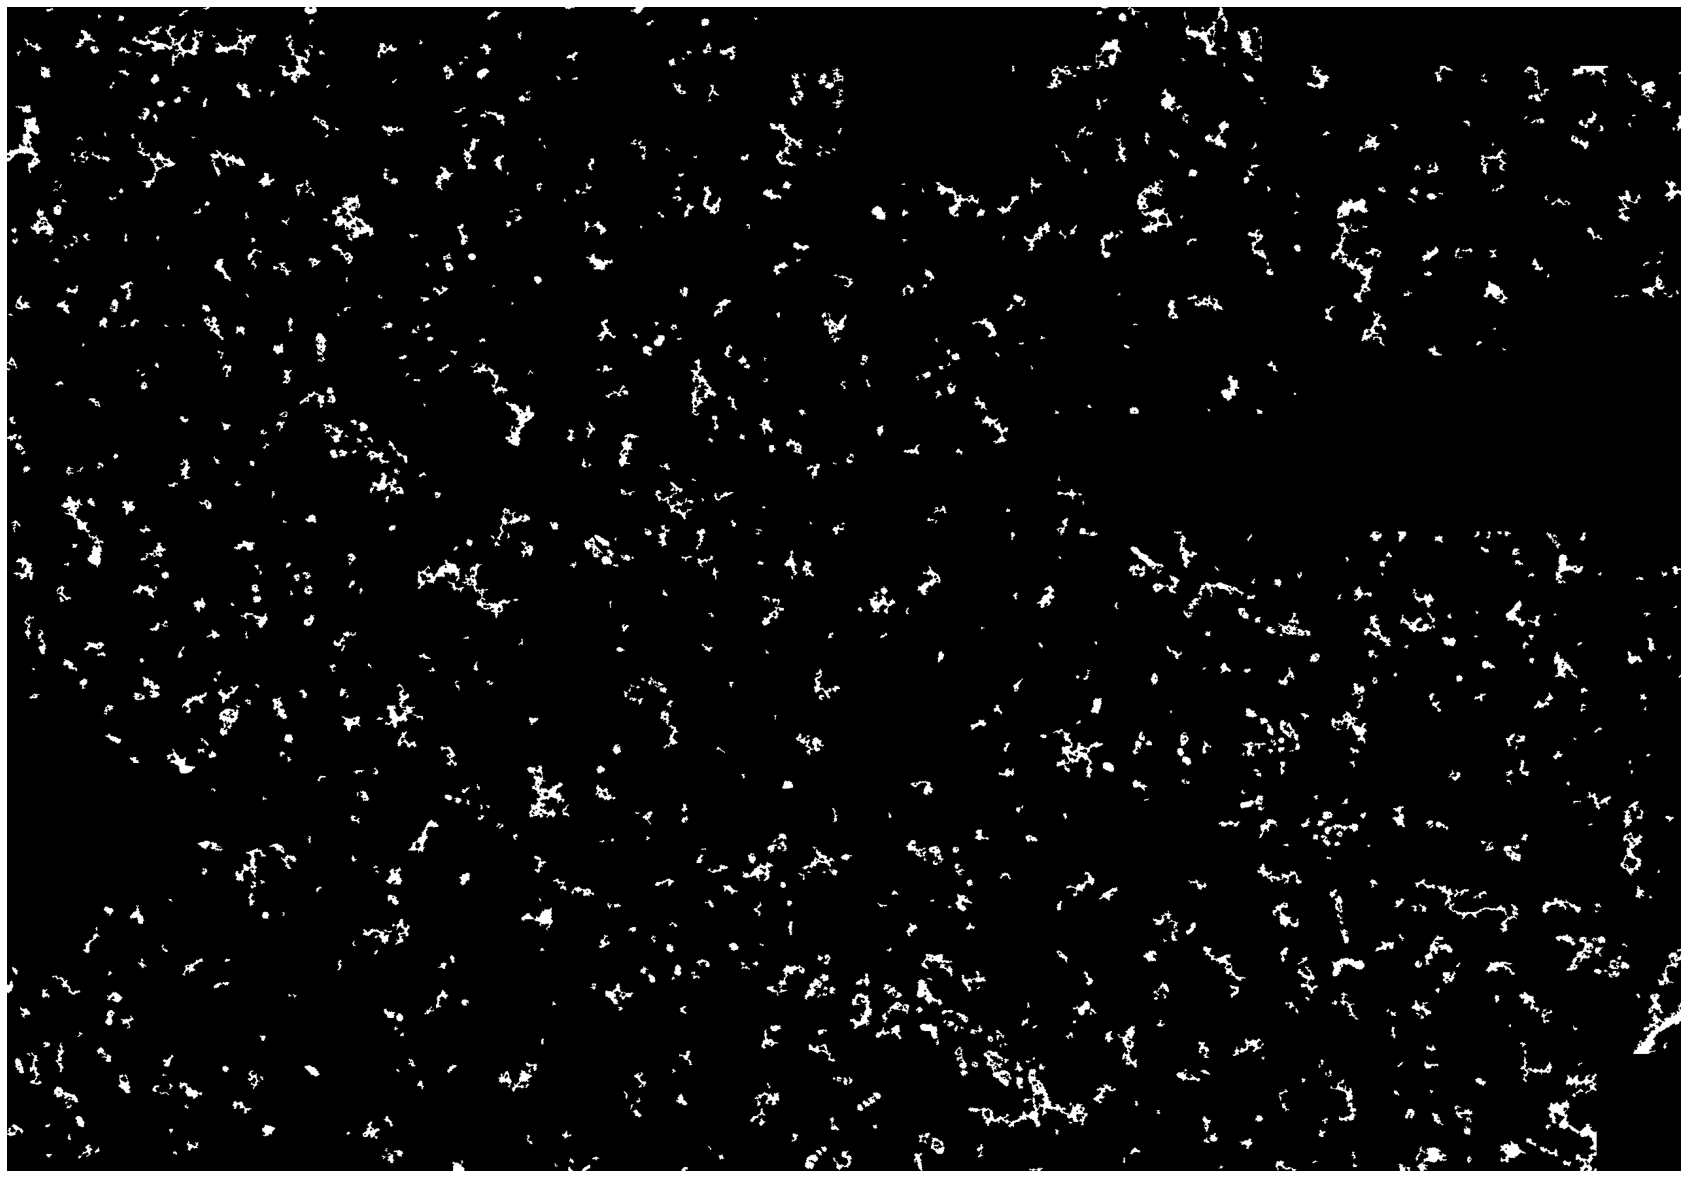

In [552]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(img_segm,vmax=1, cmap='gray')

In [553]:
def label_img():
    #img_label = label(img_denoised)
    img2_label = label(img_segm)
   # img_label = clear_border(img_label)
    #img2_label = clear_border(img2_label)
    img2_label = clear_border(img2_label, mask=mask)
    #img_label_overlay = label2rgb(img_label, bg_label=0)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())

    props = regionprops_table(img2_label, img,
                           properties=['area',
                                       'convex_area',
                                       'equivalent_diameter', 
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image'
                                       ])
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]), int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
   # data_nm = data_nm.drop(columns=['image',
   #                                 'bbox-0', 
   #                                 'bbox-1', 
    #                                'bbox-2', 
    #                                'bbox-3',
    #                                'img'])

    data_nm[data_nm.columns[0:2]].apply(lambda x:x*pixelsize)
    data_nm[data_nm.columns[0:6]].apply(lambda x:x*pixelsize)
   # data_nm[data_nm.columns[0:6]]*=pixelsize
   # data_nm[data_nm.columns[0:2]]*=pixelsize
    data_nm['circularity'] =data_nm['area']/data_nm['convex_area']
    #data_nm.to_csv('data_nm.csv')
    return img2_label, img2_label_overlay, data_nm
img2_label, img2_label_overlay, data_nm = label_img()

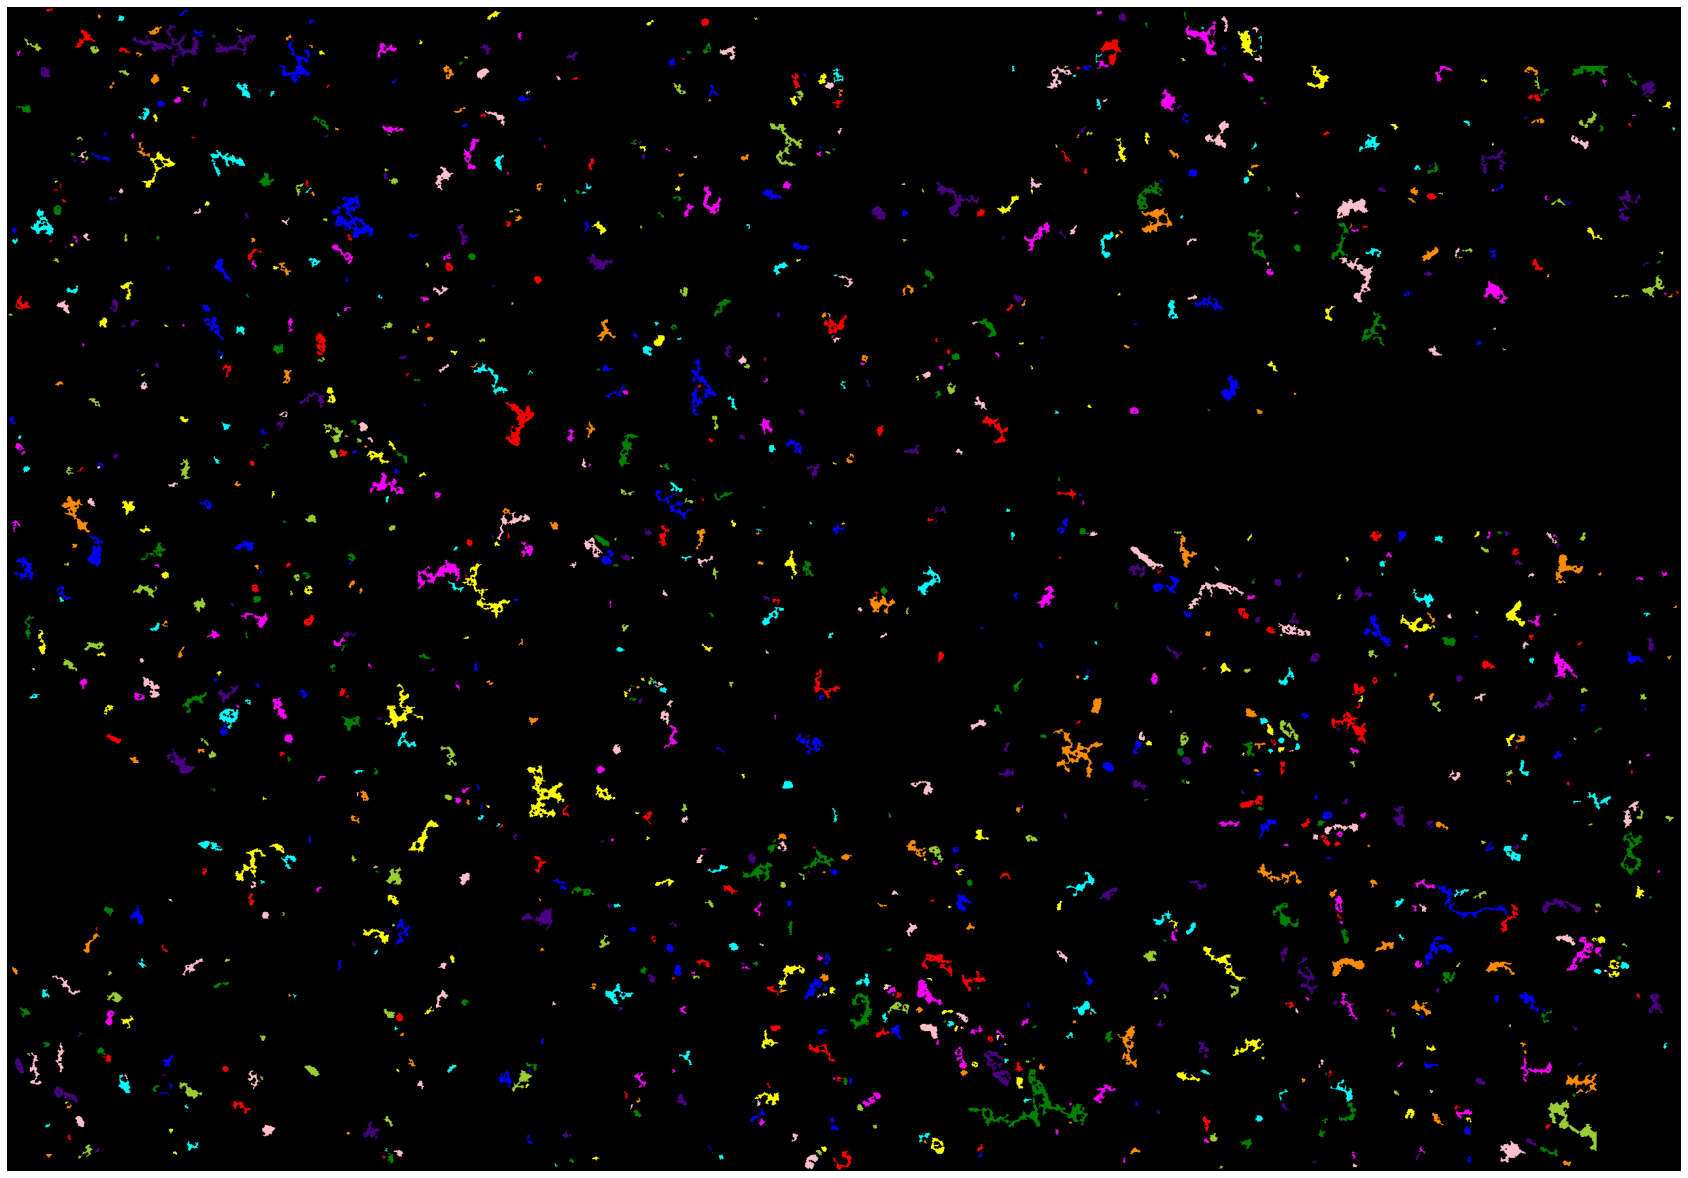

In [554]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(img2_label_overlay)

In [480]:
data_nm

area  convex_area  equivalent_diameter  major_axis_length  \
0       30           38             6.180387          10.773861   
1       44           52             7.484821          10.762741   
2       56           85             8.444016          14.467700   
3       67           86             9.236182          11.092274   
4       25           37             5.641896          11.346186   
...    ...          ...                  ...                ...   
1037    28           37             5.970821           9.464572   
1038    14           18             4.222008           6.333325   
1039   208          266            16.273716          30.712487   
1040    72           84             9.574615          10.808829   
1041    10           11             3.568248           4.472136   

      minor_axis_length  bbox-0  bbox-1  bbox-2  bbox-3  perimeter  \
0              3.856815       6    1152      14    1161  20.935029   
1              5.707594       6    2300      18    2306  25.520815   
2              7.287601       7     911      15     924  37.420310   
3              9.337894       7    2048      19    2059  35.349242   
4              3.903648       8     158      18     163  21.935029   
...                 ...     ...     ...     ...     ...        ...   
1037           4.144513    1764     804    1772     811  22.313708   
1038           3.253133    1767     149    1772     155  11.485281   
1039          10.280971    1768      92    1779     121  91.811183   
1040           9.223365    1770    2495    1779    2505  35.798990   
1041           3.200000    1775    2273    1779    2277   9.828427   

      feret_diameter_max                                              image  \
0              10.295630  [[False, True, False, False, False, False, Fal...   
1              12.165525  [[False, False, False, False, True, True], [Fa...   
2              13.341664  [[False, False, False, True, False, False, Fal...   
3              13.601471  [[False, False, True, True, False, False, Fals...   
4              10.049876  [[False, False, True, True, False], [False, Tr...   
...                  ...                                                ...   
1037            9.433981  [[False, False, False, False, False, True, Fal...   
1038            6.082763  [[False, False, False, False, True, False], [F...   
1039           29.427878  [[False, False, False, False, True, True, True...   
1040           12.206556  [[False, True, True, True, True, True, False, ...   
1041            4.472136  [[True, True, True, True], [True, True, True, ...   

                                                    img  circularity  
0     [[139.0, 146.0, 141.0, 117.0, 127.0, 122.0, 11...     0.789474  
1     [[124.0, 113.0, 125.0, 152.0, 150.0, 146.0], [...     0.846154  
2     [[133.0, 139.0, 139.0, 157.0, 150.0, 128.0, 13...     0.658824  
3     [[129.0, 150.0, 163.0, 151.0, 147.0, 153.0, 15...     0.779070  
4     [[137.0, 180.0, 205.0, 190.0, 165.0], [170.0, ...     0.675676  
...                                                 ...          ...  
1037  [[94.0, 97.0, 94.0, 102.0, 111.0, 115.0, 117.0...     0.756757  
1038  [[121.0, 115.0, 119.0, 128.0, 139.0, 128.0], [...     0.777778  
1039  [[132.0, 152.0, 187.0, 206.0, 220.0, 202.0, 18...     0.781955  
1040  [[130.0, 153.0, 163.0, 157.0, 139.0, 134.0, 12...     0.857143  
1041  [[137.0, 131.0, 115.0, 109.0], [141.0, 171.0, ...     0.909091  

[1042 rows x 14 columns]

In [372]:
import random

In [383]:
random.randint(0, len(data_nm))

338

362


(-0.5, 55.5, 91.5, -0.5)

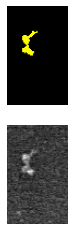

In [569]:
i = random.randint(0, len(data_nm))
print(i)
y_min = data_nm['bbox-0'][i]
y_max = data_nm['bbox-2'][i]
x_min = data_nm['bbox-1'][i]
x_max = data_nm['bbox-3'][i]

y_min -=int((y_max-y_min))
y_max +=int((y_max-y_min))
x_min -= int((x_max-x_min))
x_max += int((x_max-x_min))
plt.subplot(211)
plt.imshow(img2_label_overlay[y_min:y_max,x_min:x_max], cmap='gray')
plt.axis('off')
plt.subplot(212)
plt.imshow(img[y_min:y_max,x_min:x_max], cmap='gray')
plt.axis('off')

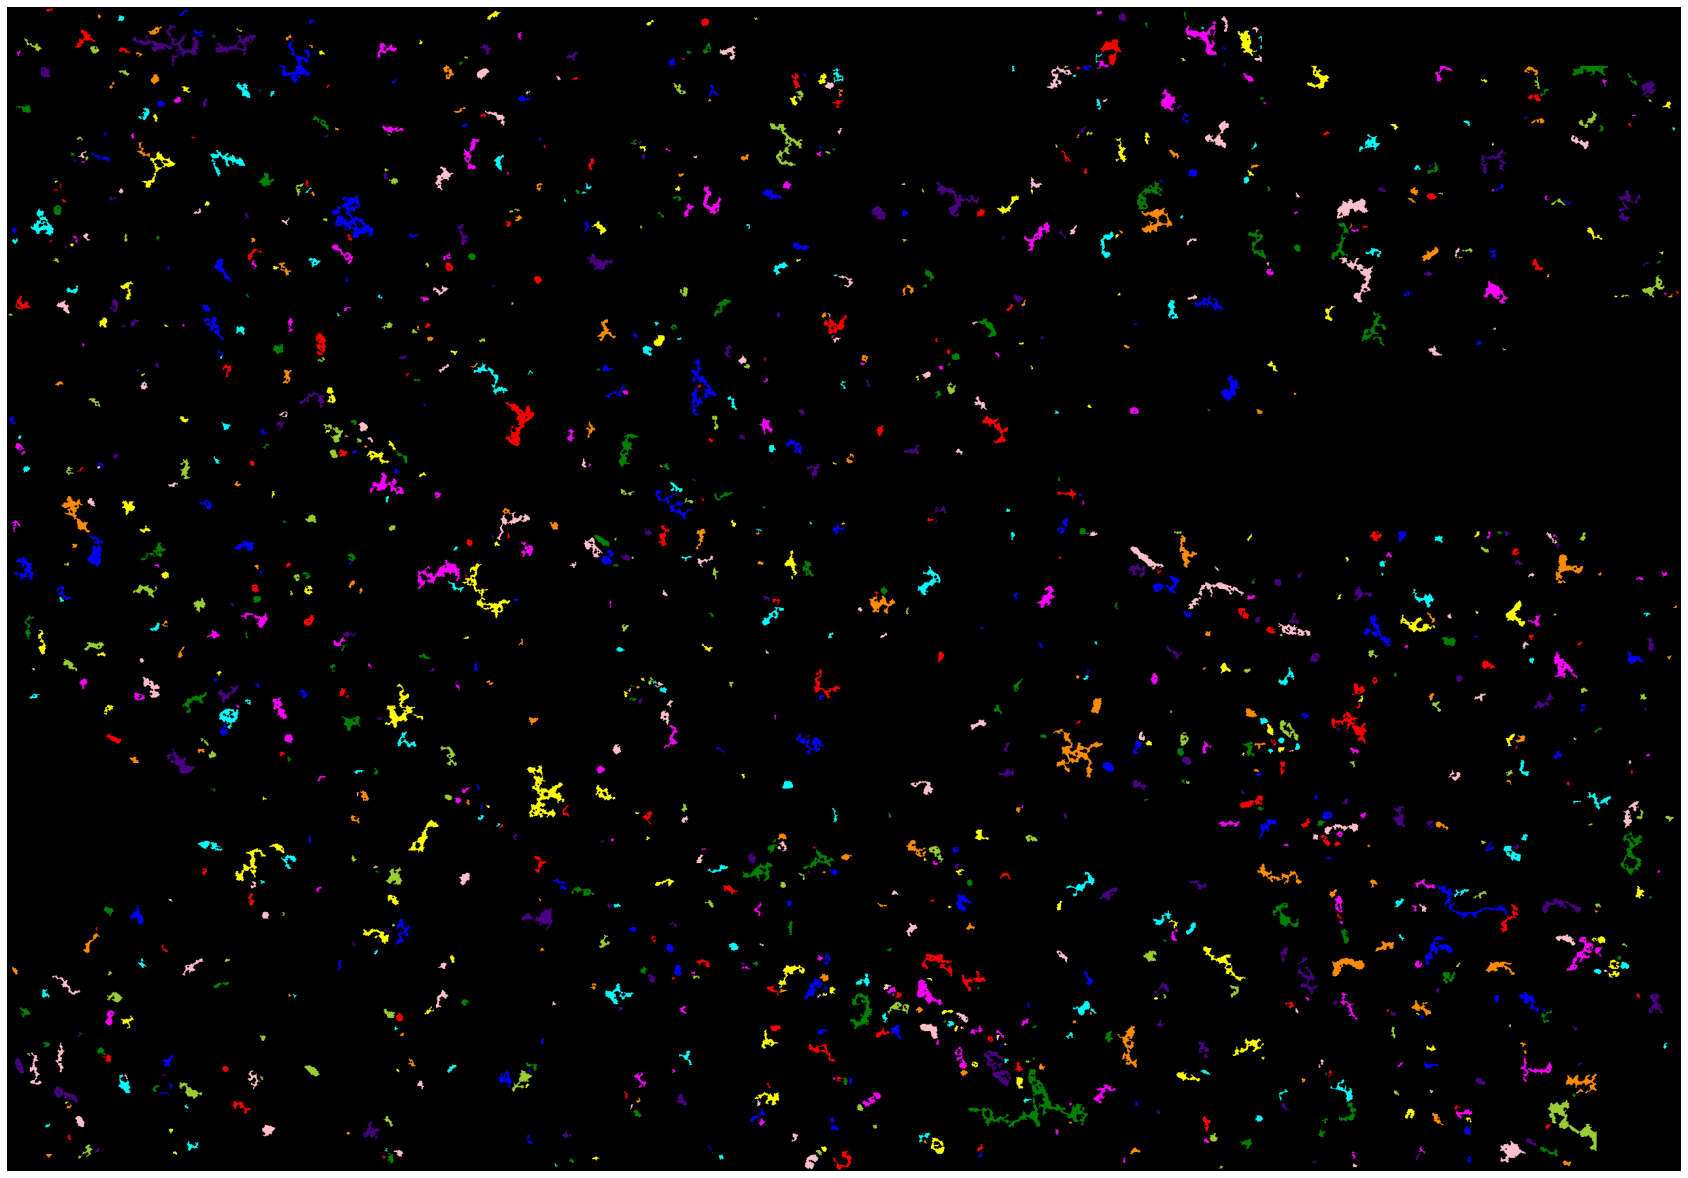

In [562]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(img2_label_overlay)

In [348]:
data_nm['area'].median()

58.0

In [ ]:
!mkdir '/content/drive/MyDrive/CIOP/images/'RESULTS

mkdir: cannot create directory ‘/content/drive/MyDrive/CIOP/images/RESULTS’: File exists


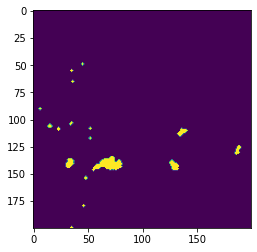

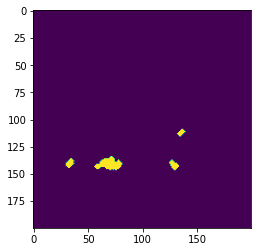

(10, 6, 10)

In [339]:
particles = []
for i in range(1,3):
    img_segm = segmentation(10,6,10,i)
    img2_label, img2_label_overlay, data_nm = label_img()
    particles.append([i,len(data_nm)])
    #name = sem_dict['ImageName'].split('.')[0]
    #plt.imsave('/content/drive/MyDrive/CIOP/images/RESULTS/'+name+str(i)+'.jpg', img2_label_overlay)

particles = pd.DataFrame(particles, columns=(['segm','number of particles']))

10,6,10

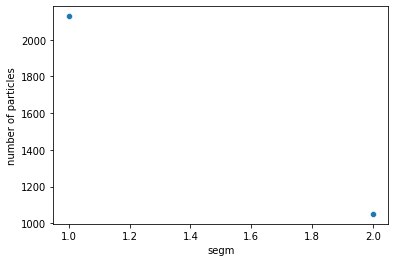

In [340]:
sns.scatterplot(data=particles,x='segm',y='number of particles')
yinterp = np.interp(particles['segm'], particles['segm'], particles['number of particles'])

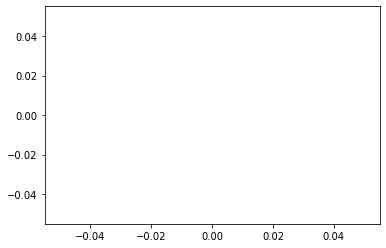

In [341]:
plt.plot(particles['number of particles'].diff().diff())

In [ ]:
particles[['segm']].values.reshape(-1,1)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20]])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
elbow = []
for i in range(2,20-2):
    lm = LinearRegression()
    temp = particles.copy()
    temp['number of particles'] = temp['number of particles']/temp['number of particles'].max()
    left = temp.iloc[:i,:]
    lm.fit(left[['segm']].values.reshape(-1,1),left['number of particles'].values)
    pred = lm.predict(left[['segm']].values.reshape(-1,1))
    mse_left = mean_squared_error(left[['number of particles']].values.reshape(-1,1),pred)
    right = temp.iloc[i:,:]
    lm.fit(right[['segm']].values.reshape(-1,1),right['number of particles'].values)
    pred = lm.predict(right[['segm']].values.reshape(-1,1))
    mse_right = mean_squared_error(right[['number of particles']].values.reshape(-1,1),pred)
    elbow.append([i,mse_left+mse_right])
print(elbow)
elbow = pd.DataFrame(elbow)

[[2, 0.0021140320987601455], [3, 0.001399754802906113], [4, 0.003989722057593591], [5, 0.008272761243588875], [6, 0.012821361882405914], [7, 0.01682911941942516], [8, 0.020192330517318918], [9, 0.02291062312859677], [10, 0.024979202907761337], [11, 0.02647729756925409], [12, 0.02743121379191068], [13, 0.028003646153363197], [14, 0.028332882163797157], [15, 0.02843695328474752], [16, 0.02838068993229242], [17, 0.02821080592707953]]


In [ ]:
elbow

0         1
0    2  0.002114
1    3  0.001400
2    4  0.003990
3    5  0.008273
4    6  0.012821
5    7  0.016829
6    8  0.020192
7    9  0.022911
8   10  0.024979
9   11  0.026477
10  12  0.027431
11  13  0.028004
12  14  0.028333
13  15  0.028437
14  16  0.028381
15  17  0.028211

In [ ]:
elbow[elbow[1] == elbow[1].min()]

0       1
1  3  0.0014

In [ ]:
m,b = np.polyfit(particles['segm'], particles['number of particles'], 1)

In [ ]:
b

2623.1315789473683

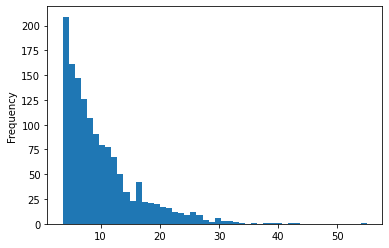

In [570]:
 data_nm['equivalent_diameter'].plot.hist(bins=50)

In [133]:
data = [67,145, 137, 132, 131, 131, 130, 129, 128, 128, 127, 127, 127, 127, 131, 132, 131, 128, 126, 126, 127, 149, 138, 132, 130, 131, 129, 129, 127, 126, 125, 124, 123, 123, 124, 124, 124, 123, 122, 123, 129, 150, 138, 132, 129, 128, 127, 127, 126, 125, 122, 121, 119, 119, 118, 118, 118, 118, 118, 120, 131, 161, 141, 134, 131, 128, 127, 126, 125, 124, 121, 119, 117, 117, 115, 114, 113, 113, 114, 118, 136, 156, 143, 132, 128, 127, 126, 125, 125, 124, 120, 118, 116, 115, 112, 112, 110, 110, 111, 115, 135, 139, 134, 127, 125, 124, 123, 123, 122, 122, 118, 116, 115, 112, 111, 111, 108, 108, 109, 113, 130, 129, 125, 124, 123, 123, 123, 123, 121, 119, 117, 114, 112, 110, 108, 108, 106, 106, 106, 109, 119, 127, 122, 122, 122, 121, 121, 121, 120, 118, 116, 113, 110, 108, 106, 105, 104, 106, 104, 107, 112, 140, 125, 123, 122, 122, 121, 121, 119, 117, 114, 111, 109, 106, 104, 103, 102, 101, 102, 105, 108, 149, 129, 123, 122, 121, 120, 120, 117, 114, 111, 107, 105, 102, 101, 100, 99, 99, 100, 102, 105, 140, 129, 124, 122, 120, 120, 119, 115, 112, 108, 104, 101, 100, 99, 98, 98, 98, 99, 101, 105, 131, 126, 124, 122, 119, 118, 116, 114, 111, 107, 103, 98, 98, 98, 97, 97, 97, 99, 100, 104, 129, 126, 124, 121, 120, 118, 116, 113, 110, 106, 103, 96, 96, 97, 97, 96, 97, 101, 101, 104, 132, 127, 123, 120, 119, 118, 114, 111, 110, 105, 102, 99, 98, 96, 95, 95, 96, 97, 100, 104, 130, 125, 121, 119, 117, 114, 113, 109, 106, 104, 101, 98, 97, 95, 94, 95, 94, 95, 98, 101, 127, 123, 120, 117, 115, 112, 110, 107, 105, 102, 101, 98, 97, 94, 93, 93, 93, 94, 96, 99, 125, 122, 118, 115, 112, 110, 108, 105, 102, 100, 98, 97, 95, 93, 92, 91, 92, 92, 94, 97, 121, 119, 115, 113, 110, 108, 105, 103, 101, 99, 97, 96, 93, 92, 91, 91, 92, 92, 94, 97, 117, 117, 113, 113, 109, 106, 103, 101, 100, 97, 95, 94, 92, 91, 91, 90, 90, 92, 93, 97, 116, 117, 114, 111, 108, 105, 102, 100, 98, 97, 96, 93, 92, 90, 90, 90, 90, 91, 93, 97]

In [134]:
np.max(data)

161

In [135]:
np.median(data)

113.0

In [136]:
Q1 ,Q2, Q3 = np.percentile(data, [25,50,75])

In [137]:
print(Q1,Q2,Q3)

101.0 113.0 123.0


In [138]:
IQR = Q3-Q1

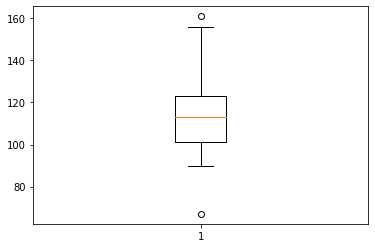

In [139]:
plt.boxplot(data)
plt.show()

In [140]:
Q3+1.5*IQR

156.0

In [141]:
Q1-1.5*IQR

68.0